In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

## Set-up

In [2]:
def build_dataset(words, block_size, stoi, print_shape=False):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  if print_shape:
    print(X.shape, Y.shape)
  return X, Y

In [3]:
words = open('../lectures/makemore/names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(chars)

block_size = 3 # how many characters do we take to predict the next one?
emb_dim = 10

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size, stoi)
Xdev, Ydev = build_dataset(words[n1:n2], block_size, stoi)
Xte, Yte = build_dataset(words[n2:], block_size, stoi)

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, emb_dim), generator=g)
W1 = torch.randn((emb_dim * block_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]

print(f"parameter count: {sum(p.nelement() for p in parameters)}")

for p in parameters:
  p.requires_grad = True

lri = []
lossi = []
stepi = []

parameter count: 11897


## Training and evaluation

In [4]:
for i in range(200_000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (64,)) # changing the batch size here is enough to beat the original loss!
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

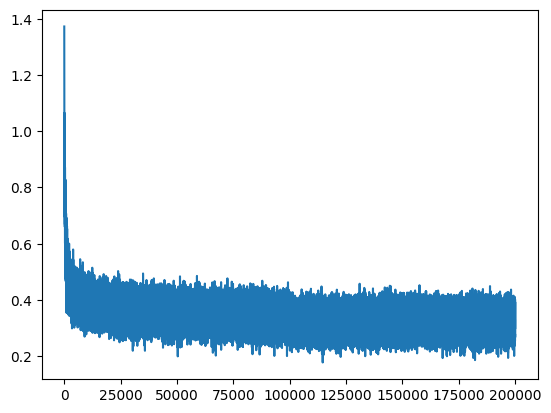

In [5]:
plt.plot(stepi, lossi)

In [6]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
print(f"train loss: {F.cross_entropy(logits, Ytr):.5f}")

emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) 
logits = h @ W2 + b2
print(f"dev loss: {F.cross_entropy(logits, Ydev):.5f}")

train loss: 2.12322
dev loss: 2.16321


## Inference

In [7]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khy.
mili.
taty.
skaassa.
jazhite.
deliah.
jareei.
ner.
kea.
chaiir.
kaleigh.
ham.
joce.
quint.
suline.
livani.
wazelogiearynix.
kael.
